# DS-GA 1018: Probabilistic Time Series Analysis

# Spectral Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Below is the function for generating the datasets. The first dataset is stationary, and is given by:

$y_{s}(t) = \sum_{\{\omega\}} \sin (\omega t) + \eta(t)$,

where $\eta(t) \sim \mathcal{N}(0, \sigma^2)$.

The second dataset is nonstationary, and is given by:

$y_{ns}(t) = m_1(t) \sum_{\{\omega_1\}} \sin(\omega_1 t) + m_2(t) \sum_{\{\omega_2\}} \sin(\omega_2 t) + \eta(t)$,

where again $\eta(t) \sim \mathcal{N}(0, \sigma^2)$, $m_1(t)$ and $m_2(t)$ are positive nonstationary processes, and
the sets $\{\omega_1\}$ and $\{\omega_2\}$ define two separate sets of frequencies, each associated with a separate modulator.

We will be exploring the relationship between each process and its power spectrum.

In [2]:
def bump_fn(x, lengthscale):
    return np.exp(-x**2/lengthscale**2)

def gen_stationary_dataset(sigma, freq, tstep):
    """Function for generating a stationary signal
    Inputs:
    freq- an array of the frequencies to include in the signal
    sigma- the standard deviation of additive white noise
    tstep- the number of time steps to include in the data
    Outputs:
    data - time series of the stationary data
    """
    noise = np.random.normal(scale = sigma, size = int(tstep))
    time = np.arange(0, tstep)
    signal = np.sum(np.sin(np.outer(2 * np.pi * freq,time)), axis = 0)
    
    data = signal + noise
    return data

def construct_modulator(tstep, envelope_lengthscale):
    """Function for generating a nonstationary modulator
    Inputs:
    tstep - the number of time steps
    envelope lengthscale - the width of the modulator"""
    time = np.arange(0, tstep)
    bump_x = np.arange(-200, 200)
    bump = bump_fn(bump_x, envelope_lengthscale)
    
    modulator_idx = np.random.choice(time, size = 10)
    modulator = np.zeros(tstep)
    modulator[modulator_idx] = 1
    modulator = np.convolve(modulator, bump, mode = 'same')
    
    return modulator
def gen_nonstationary_dataset(sigma, freq, freq_2, tstep, envelope_lengthscale):
    """Function for generating a nonstationary signal
    Inputs:
    freq- an array of the frequencies to include in the first signal
    freq2 - an array of the frequencies to include in the second signal
    sigma- the standard deviation of additive white noise
    tstep- the number of time steps to include in the data
    envelope_lengthscale- the width of the modulator
    Outputs:
    data_nonstationary - time series of the nonstationary data
    """
    
    modulator_1 = construct_modulator(tstep, envelope_lengthscale)
    modulator_2 = construct_modulator(tstep, envelope_lengthscale)
    
    data_stationary_1 = gen_stationary_dataset(sigma, freq, tstep)
    data_stationary_2 = gen_stationary_dataset(sigma, freq_2, tstep)
    
    data_nonstationary = modulator_1 * data_stationary_1 + modulator_2 * data_stationary_2 
    
    return data_nonstationary, modulator_1, modulator_2

### Computing the Power Spectrum

The power spectrum of a signal is given by:

$S(f) = \left | a(f) \right | ^2$,

where $a(f)$ is the Fourier coefficient for frequency $f$, computed using the Fourier transform.

In the following section, you will compute the power spectrum using the Fast Fourier Transform (try numpy.fft.fft).

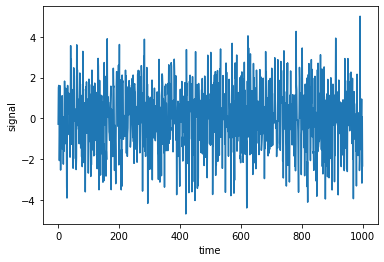

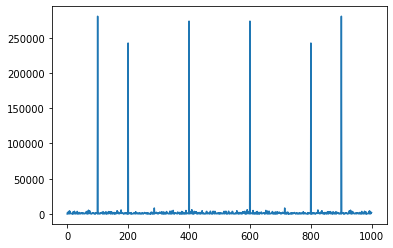

In [3]:
#plot the stationary process
sigma = 1
freq = np.array([0.1, 0.2, 0.4])
tstep = 1000
data_stationary = gen_stationary_dataset(sigma, freq, tstep)

plt.figure()
plt.plot(np.arange(0, tstep), data_stationary)
plt.xlabel('time')
plt.ylabel('signal')

###TODO: use the numpy fft function to plot the power spectrum of the data###
plt.figure()
power_spectrum = np.abs(np.fft.fft(data_stationary))**2
frequency = np.linspace(0,tstep,len(power_spectrum))
plt.plot(frequency,power_spectrum)


###TODO: re-plot the data for increased values of sigma.
### What happens as you increase sigma? Why does it happen?


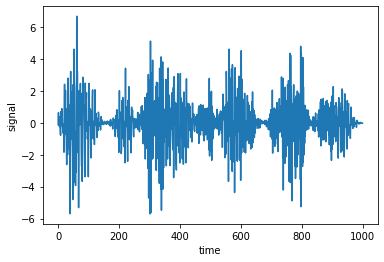

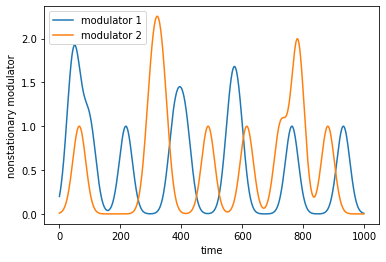

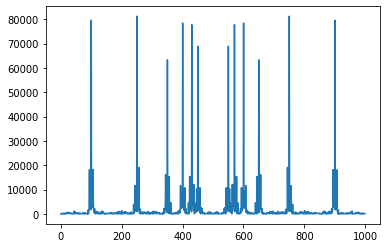

In [4]:
#plot the nonstationary process
sigma = 0.5
freq = np.array([0.1, 0.25, 0.35])
freq_2 = np.array([0.4, 0.43, 0.45])
tstep = 1000
envelope_lengthscale = 30
data_nonstationary, modulator_1, modulator_2 = gen_nonstationary_dataset(sigma, freq, freq_2, tstep, envelope_lengthscale)

plt.figure()
plt.plot(np.arange(0, tstep), data_nonstationary)
plt.ylabel('signal')
plt.xlabel('time')

plt.figure()
plt.plot(np.arange(0, tstep), modulator_1)
plt.plot(np.arange(0, tstep), modulator_2)
plt.legend(('modulator 1', 'modulator 2'))
plt.ylabel('nonstationary modulator')
plt.xlabel('time')

###TODO: use the numpy fft function to plot the power spectrum of the data###
plt.figure()
power_spectrum = np.abs(np.fft.fft(data_nonstationary))**2
frequency = np.linspace(0, tstep, len(power_spectrum))
plt.plot(frequency,power_spectrum)

### Computing a spectrogram

Here, we will adapt the power spectrum to gather spectral information over shorter periods of time. This will allow us to analyze nonstationarities in our signal.

In [6]:
def power_spectrum_window(data, window_size):
    ### TODO: write a function that returns a (len(data)-window_size) x window_size matrix
    ### where the ith column gives the power spectrum of the data for the data from i-window_size/2:i+window_size

    pspectrum = np.zeros((len(data)-window_size, window_size))

    for i in range(window_size//2,len(data)-window_size//2):

      #calculate the power spectrum of data from [i-window_size/2:i+window_size]
      power_spectrum = np.abs(np.fft.fft(data[i-window_size//2:i+window_size//2]))**2
    
      pspectrum[i-window_size//2,:]= power_spectrum

    return pspectrum

Text(0.5, 0, 'time')

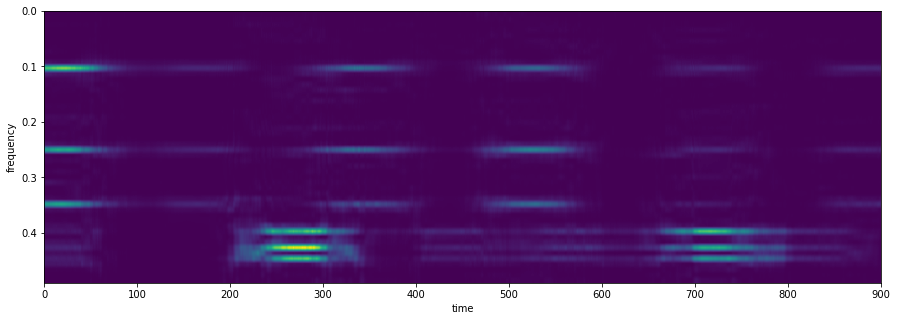

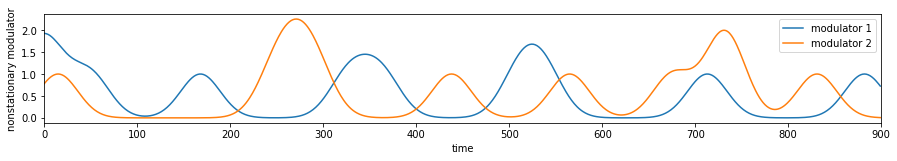

In [7]:
window_size = 100
pspectrum = power_spectrum_window(data_nonstationary, window_size)
freq = np.fft.fftfreq(window_size)
fig, ax = plt.subplots(figsize = (15,5))
extent = (0, 900, max(freq), 0)
ax.imshow(pspectrum.T[0:int(window_size/2),:], aspect = 'auto', extent = extent)
plt.xlabel('time')
plt.ylabel('frequency')

plt.subplots(figsize = (15,2))
plt.plot(np.arange(0, tstep-window_size), modulator_1[int(window_size/2):int(tstep-window_size/2)])
plt.plot(np.arange(0, tstep-window_size), modulator_2[int(window_size/2):int(tstep-window_size/2)])
plt.legend(('modulator 1', 'modulator 2'))
plt.xlim([0, tstep-window_size])
plt.ylabel('nonstationary modulator')
plt.xlabel('time')

###TODO: Plot the temporal power spectrum for a smaller sliding window and for a larger window. What happens, and why?

### Please turn in the code and pdf before 12/14/2021 at 11:59 pm. Please name your notebook netid.ipynb. 